# GPU사용

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: 


2022-02-25 12:02:12.096441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.


Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-02-25 12:02:12.096576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### train dataset 호출

In [9]:
#create training dataset
from glob import glob
import numpy as np
import PIL
from PIL import Image

path = './train/'

training_images = []
training_labels = []

for filename in glob(path +"*"):
    for img in glob(filename + "/*.jpg"):
        print("now:",img )
        an_img = PIL.Image.open(img)
        # an_img = PIL.Image.open(img).convert('L') #read img to gray
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images 
        label = filename.split('/')[-1] #get label
        print("label:",label)
        training_labels.append(label) #append label
        print("끝")

training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(0,)
(0, 1)


## test dataset 호출

In [ ]:
#create test dataset

path = 'test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    print("now:",filename )
    an_img = PIL.Image.open(filename)
    # an_img = PIL.Image.open(filename).convert('L') #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    
    label = filename.split('/')[1] #get id 
    test_idx.append(label) #append id
    print("label:",label)
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

# 0~1 Scale

In [ ]:
training_images = training_images/255.0

test_images = test_images/255.0

# 데이터 shuffle

In [ ]:
idx = np.arange(training_images.shape[0])
np.random.shuffle(idx)

In [ ]:
idx

array([31361, 26892, 37056, ..., 30620, 23934,  7958])

In [ ]:
shuffle_images = training_images[idx]
shuffle_labels = training_labels[idx]

### 해야할것 
## 1. xavier 초기화 / conv2d에는 이미 적용이 되있음 /Dense에 적용 O
## 2. 데이터 전처리(/255.0) / O
## 3. 여러 콜백 / O(ES / lr decay)
## 4. 모델 재구성 (ResNet은 파라미터의 숫자가 방대하기에 colab에서 돌리지 못할 것 같음)
## 5. 데이터 증량
## 6. k-fold / O
## 7. 앙상블
## 8. non color > to gray

#모델구조

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    tf.keras.layers.Dropout(0.35)

    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.35),


    tf.keras.layers.Flatten(), # N차원 배열 -> 1차원 배열
    tf.keras.layers.Dense(256, activation = 'relu',kernel_regularizer='l2',kernel_initializer=tf.keras.initializers.GlorotNormal()), #fully connected layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation = 'relu',kernel_initializer=tf.keras.initializers.GlorotNormal()), #fully connected layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [ ]:
optim_adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optim_adam, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1

# K-Fold
## k-fold를 통해 최대한 모든 데이터를 학습에 사용하고자 함.

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau # EarlyStopping > 중도 학습 중단 / ReduceLROnPlateau 중도 학습률 변경

In [ ]:
kfold = KFold(n_splits= 5) # 5개의 fold 수 즉 test 4만개 /validation 1만개

In [ ]:
with tf.device('/device:GPU:0'):
  fold_count = 0
  for train_idx, validataion_idx in kfold.split(shuffle_images): # shuffle_images (5만개)의 데이터를 kfold
    X_train , X_valid = shuffle_images[train_idx] , shuffle_images[validataion_idx]
    y_train , y_valid = shuffle_labels[train_idx] , shuffle_labels[validataion_idx]

    print("fold_count =",fold_count)
    # cb_early_stopping = EarlyStopping(monitor='val_loss', patience=8,verbose= 1) # 현재는 earlystop을 사용하지 않음(why? > k-fold를 통해 최대한 학습을 하고 싶음)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.0001,verbose = 1) # 학습률을 0.0001까지 줄일수 있음

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=512, 
              callbacks=[reduce_lr],shuffle=True)
    fold_count += 1

fold_count = 0
Epoch 1/20
79/79 [==============================] - 30s 224ms/step - loss: 4.6468 - accuracy: 0.2990 - val_loss: 2.9949 - val_accuracy: 0.2049 - lr: 0.0100
Epoch 2/20
79/79 [==============================] - 13s 170ms/step - loss: 2.2127 - accuracy: 0.4092 - val_loss: 3.0654 - val_accuracy: 0.2334 - lr: 0.0100
Epoch 3/20
79/79 [==============================] - 13s 171ms/step - loss: 2.2248 - accuracy: 0.4656 - val_loss: 2.7601 - val_accuracy: 0.3000 - lr: 0.0100
Epoch 4/20
79/79 [==============================] - 13s 171ms/step - loss: 2.1952 - accuracy: 0.5087 - val_loss: 2.7714 - val_accuracy: 0.3395 - lr: 0.0100
Epoch 5/20
79/79 [==============================] - 14s 171ms/step - loss: 2.1544 - accuracy: 0.5399 - val_loss: 2.2872 - val_accuracy: 0.4906 - lr: 0.0100
Epoch 6/20
79/79 [==============================] - 14s 171ms/step - loss: 2.0174 - accuracy: 0.5837 - val_loss: 2.4381 - val_accuracy: 0.4390 - lr: 0.0100
Epoch 7/20
79/79 [==============================]

# 결과 시각화
## 여기서는 마지막 k-fold의 데이터만 시각화를 해서 그래프가 이상함. (수정예정)

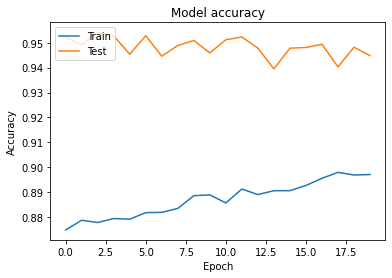

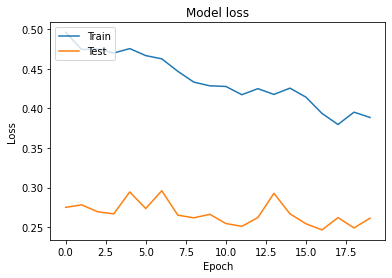

In [ ]:
import matplotlib.pyplot as plot

plot.plot(history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [ ]:
pred_proba = model.predict(test_images) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'bird', 'airplane', 'cat', 'airplane'], dtype='<U10')

In [ ]:
import pandas as pd

sample_submission = pd.read_csv("/content/drive/MyDrive/[데이콘] 사물 이미지 분류/dataset/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit.csv",index=False)

In [ ]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,bird
2,0002.jpg,airplane
3,0003.jpg,cat
4,0004.jpg,airplane


# 끝!